### Persons in the geographical space

We present various methods of spatialising the birthplaces of our population.

Cf. Sparqlbook [Import birth places](../../sparqlbooks/wdt_import_birth_places.sparqlbook.md)

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from shapely import wkt

import scipy.stats as stats

from geopandas.tools import sjoin
#from geodatasets import get_path

In [3]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import plotly.express as px
import plotly.graph_objects as go

import json

import numpy as np
import seaborn as sns
import math
import os

In [4]:
### Librairies déjà installées avec Python
import pprint
import csv


from shutil import copyfile


In [5]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [ ]:
print(reload(naf))  

<module 'network_analysis_functions' from '/home/francesco/kDrive/python_notebooks/astronomers/notebooks_jupyter/wikidata_exploration/../network_analysis_functions.py'>


## Geo data

[Word Regions (ESRI)](https://hub.arcgis.com/datasets/a79a3e4dc55343b08543b1b6133bfb90/explore?location=-0.027457%2C0.000000%2C0.88). For personal use only

In [6]:
world_filepath = '../geo_data/esri/World_Regions_6144914380456424035.geojson'
world = gpd.read_file(world_filepath)
world.head()

,FID,REGION,SQMI,SQKM,geometry
0,1,Asiatic Russia,4.987737e+06,1.291823e+07,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,2,Australia/New Zealand,3.077219e+06,7.969992e+06,"MULTIPOLYGON (((158.88218 -54.71139, 158.87967..."
2,3,Caribbean,8.919361e+04,2.310113e+05,"MULTIPOLYGON (((-60.92305 10.79722, -60.94445 ..."
3,4,Central America,9.576923e+05,2.480422e+06,"MULTIPOLYGON (((-81.67847 7.38861, -81.64945 7..."
4,5,Central Asia,1.612212e+06,4.175626e+06,"POLYGON ((53.90564 37.35086, 53.67731 37.33536..."


In [7]:
### Inspect the projection
pprint.pprint(world.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



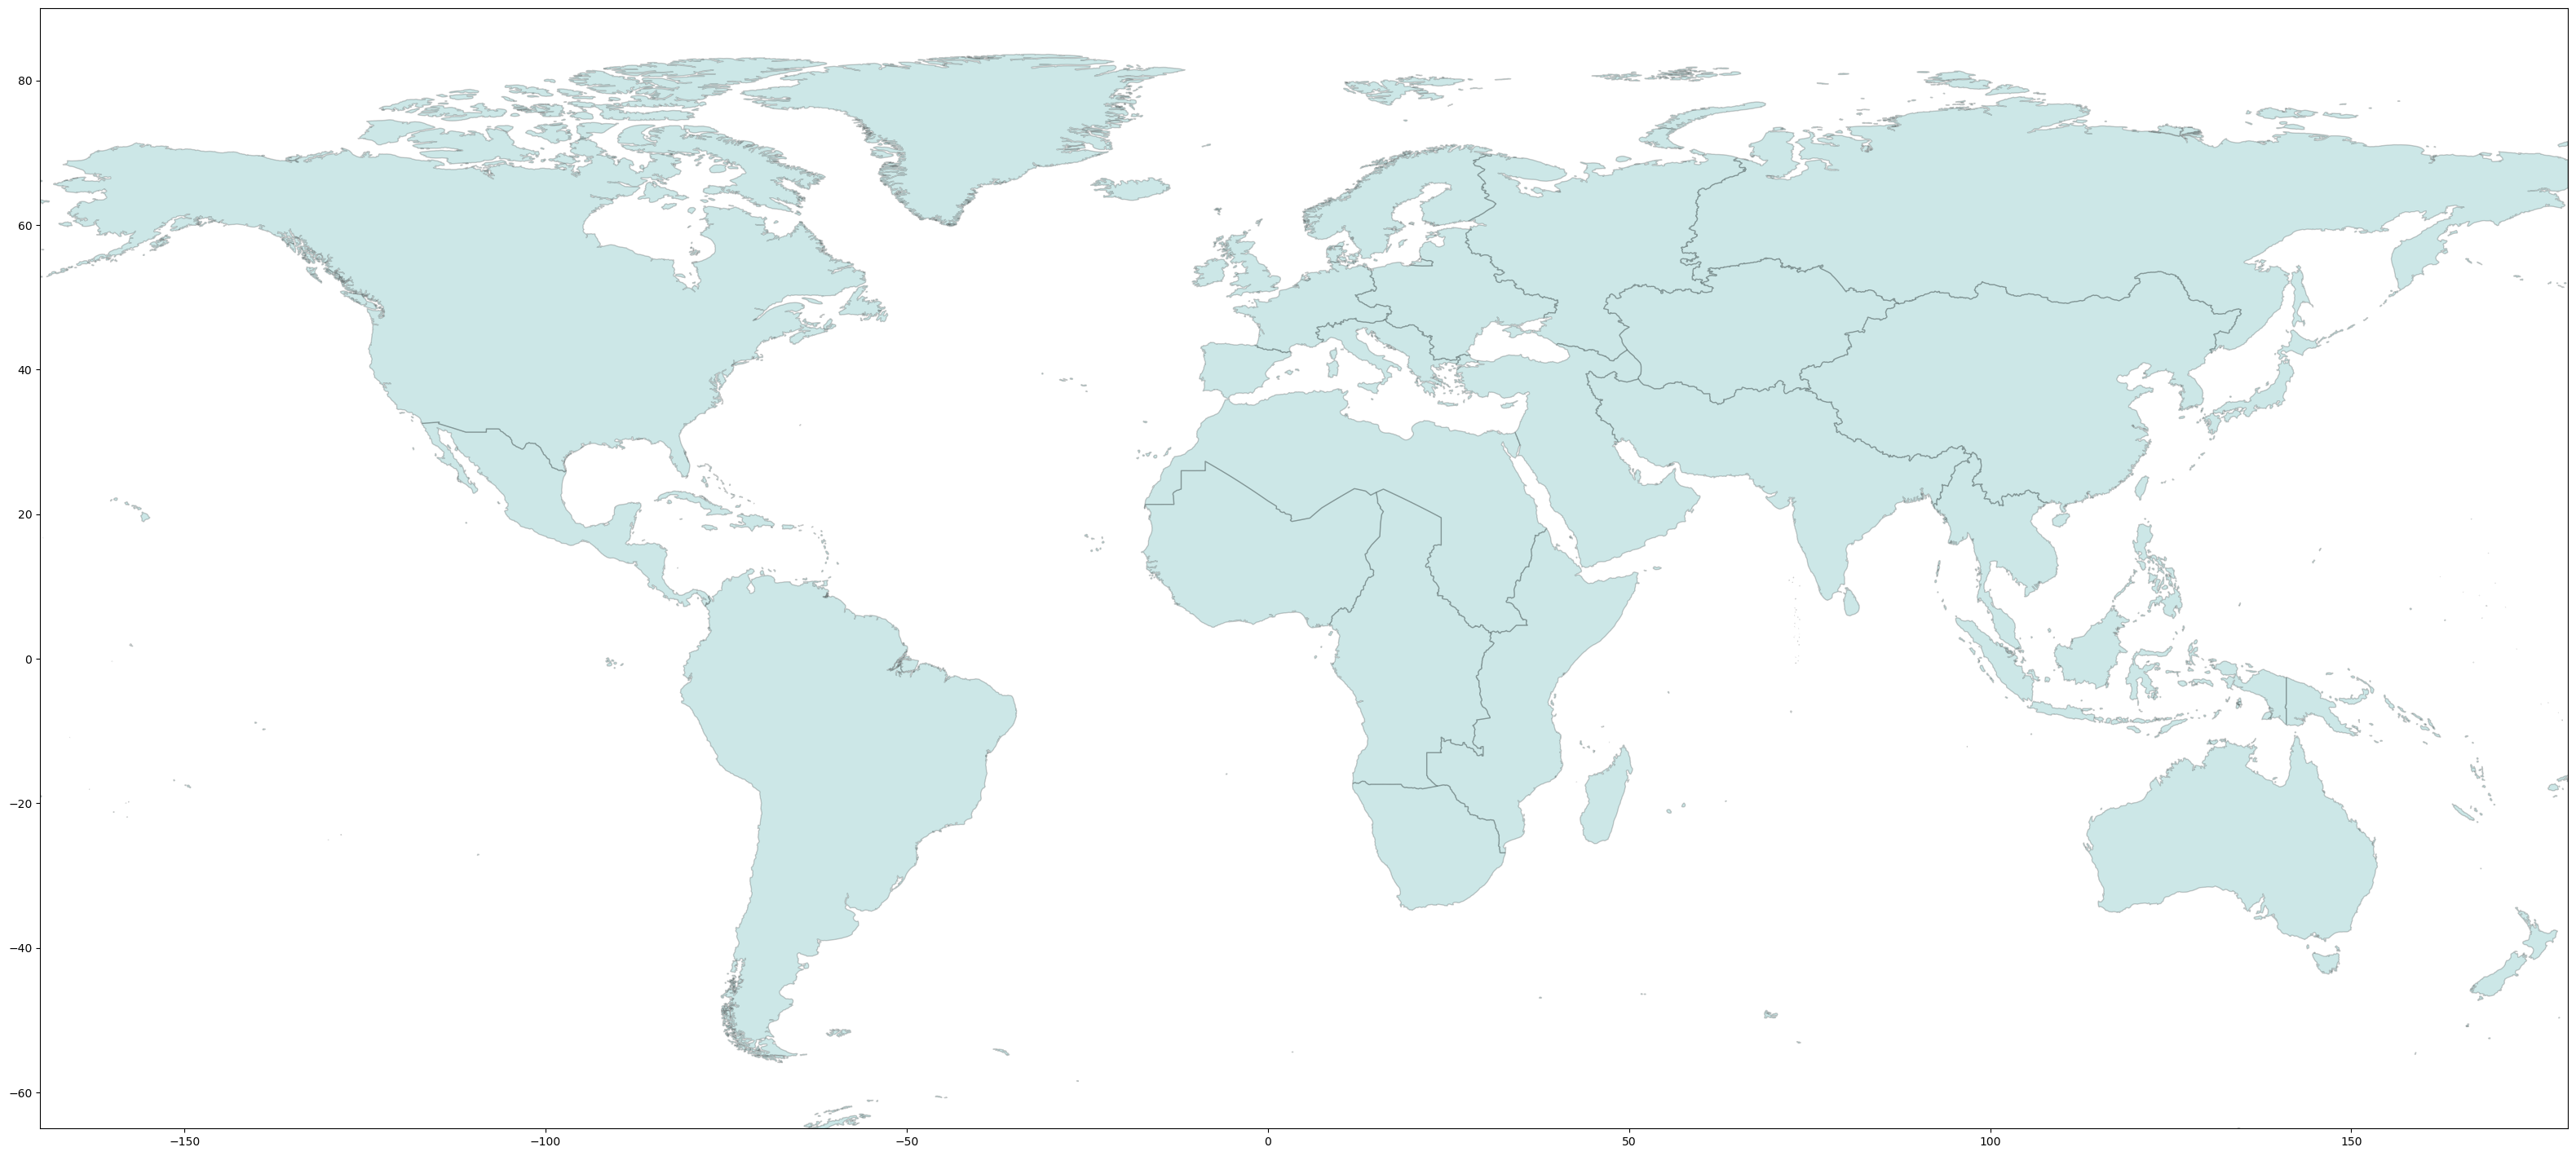

In [ ]:
### Draw the world map

## GeoPandas documentation
# https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html

# If we want to exclude the Antarctic region
world.clip([-180.0, -10.0, 180.0, 90.0])

ax = world.plot(color="DarkCyan", alpha=0.2, edgecolor="black", figsize=(40,30))

# If we want to exclude the Antarctic region
ax.set_xlim(-170,180)
ax.set_ylim(-65, 90)


plt.show()



## Get the data from the triplestore



In [ ]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [ ]:
### This query eliminates double names of persons and places,
# and double locations for the same place, and multiple birth dates
query = """
### Nombre de personnes
PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?person 
        (MIN(?personLabel) AS ?persLabel) 
        (MIN(?bDate) AS ?birthDate)
         ?geoPlace 
        (MIN(?placeLabel) AS ?geoPlaceLabel)
        (MIN(?location) AS ?minLocation)
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {
            ?person a wd:Q5;
                rdfs:label ?personLabel;
                wdt:P569 ?bDate;
                wdt:P19 ?geoPlace.
            ?geoPlace wdt:P625 ?location;
                rdfs:label ?placeLabel.   
          }
}
GROUP BY ?person ?geoPlace
ORDER BY ?person ?geoPlace
"""

In [ ]:
### Excecute the query and transform result to list
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[101:103])
except Exception as e:
    print(e)    


## Inspect the data


In [ ]:
### Create and inspect the dataframe
df_p = pd.DataFrame(out)
df_p.head(1)

,0,1,2,3,4,5
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,http://www.wikidata.org/entity/Q3951,Aalen,Point(10.093611111 48.837222222)


In [ ]:
### Add column names and inspect length of dataframe
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'uriPlace', 'labelPlace',
                'geometry']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]

Number:  22061


,uriPer,labelPer,birthYear,uriPlace,labelPlace,geometry
10,http://www.wikidata.org/entity/Q100234663,Henri Benoît,1921,http://www.wikidata.org/entity/Q6441,Montpellier,Point(3.877230555 43.610919444)
11,http://www.wikidata.org/entity/Q100235232,Joseph Johnson III,1940,http://www.wikidata.org/entity/Q23197,Nashville,Point(-86.774444444 36.162222222)
12,http://www.wikidata.org/entity/Q100276765,Charles-Henri Tabareau,1790,http://www.wikidata.org/entity/Q174019,Béziers,Point(3.216111111 43.343333333)


#### Save dataframe to CSV

In [ ]:
file_add = 'data/geoloc_persons_birth.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

#### Reload dataframe from CSV if needed

In [9]:
### Load from CSV if needed
file_add = 'data/geoloc_persons_birth.csv'

df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

22061


,uriPer,labelPer,birthYear,uriPlace,labelPlace,geometry
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,http://www.wikidata.org/entity/Q3951,Aalen,Point(10.093611111 48.837222222)
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,http://www.wikidata.org/entity/Q27678,Holstebro,Point(8.6175 56.358055555)


### Treat multiple birth places

In [10]:
### Prepare a field that concatenates the values
# for places 
df_p['concat_place'] = df_p.apply(lambda x: (x.labelPlace + ';' + x.uriPlace + ';' + x.geometry), axis=1)

In [11]:
### Aggregate the places per person

df_pgr=df_p[['uriPer', 'labelPer', 'birthYear', 'concat_place']].groupby(['uriPer', 'labelPer', 'birthYear'],
               as_index=False)\
.agg({'concat_place': '|'.join})
print('Number of persons in dataframe: ', len(df_pgr), '\n---')
df_pgr.head(3)


Number of persons in dataframe:  21861 
---


,uriPer,labelPer,birthYear,concat_place
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,Aalen;http://www.wikidata.org/entity/Q3951;Poi...
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,Holstebro;http://www.wikidata.org/entity/Q2767...
2,http://www.wikidata.org/entity/Q1001072,Salomo Sachs,1772,Berlin;http://www.wikidata.org/entity/Q64;Poin...


In [12]:
### Verify that persons are unique
pers_grouped = df_pgr.groupby('uriPer').size().sort_values(ascending=False)
print('Number of unique persons: ', len(pers_grouped), '\n---')
# print(pers_grouped.describe())
pers_grouped.head()

Number of unique persons:  21861 
---


uriPer
http://www.wikidata.org/entity/Q999927       1
http://www.wikidata.org/entity/Q1000193      1
http://www.wikidata.org/entity/Q1000934      1
http://www.wikidata.org/entity/Q1001072      1
http://www.wikidata.org/entity/Q100153910    1
dtype: int64

In [13]:
### This persons has three birth dates in the orginal data
# this is now cleaned up in the SPARQL query
df_pgr.loc[df_pgr.uriPer.str.contains('Q1243596')]

,uriPer,labelPer,birthYear,concat_place
3525,http://www.wikidata.org/entity/Q1243596,Giovanni Battista Guglielmini,1760,Bologna;http://www.wikidata.org/entity/Q1891;P...


In [14]:
df_pgr.loc[df_pgr.uriPer.str.contains('Q117884158')].head()

,uriPer,labelPer,birthYear,concat_place
2627,http://www.wikidata.org/entity/Q117884158,Vasyl Mykolayovych Ivchenko,1948,Kyiv Oblast;http://www.wikidata.org/entity/Q17...


In [15]:
### Count the birth places
# The most frequent, first

df_pgr['number'] = df_pgr.concat_place.apply(lambda x : len(x.split('|')))
df_pgr.sort_values("number",ascending=False).head()

,uriPer,labelPer,birthYear,concat_place,number
6308,http://www.wikidata.org/entity/Q16509171,Daniel Charles Mattis,1932,Brussels;http://www.wikidata.org/entity/Q11190...,3
9864,http://www.wikidata.org/entity/Q25455134,Mustapha Ishak-Boushaki,1967,Thénia;http://www.wikidata.org/entity/Q2225013...,3
7089,http://www.wikidata.org/entity/Q1763302,Stephen Brush,1935,Orono;http://www.wikidata.org/entity/Q2736049;...,3
2627,http://www.wikidata.org/entity/Q117884158,Vasyl Mykolayovych Ivchenko,1948,Kyiv Oblast;http://www.wikidata.org/entity/Q17...,3
20988,http://www.wikidata.org/entity/Q95141162,Arnošt Mikulaschek,1900,Šternberk;http://www.wikidata.org/entity/Q3924...,2


In [16]:
### An example
pprint.pprint(str(df_pgr.loc[df_pgr.uriPer.str.contains('Q1763302')]['concat_place'].to_list()))

("['Orono;http://www.wikidata.org/entity/Q2736049;Point(-68.672 44.883)|United "
 'States;http://www.wikidata.org/entity/Q30;Point(-98.5795 '
 '39.828175)|Bangor;http://www.wikidata.org/entity/Q327012;Point(-68.7675 '
 "44.803055555)']")


In [17]:
### Number of persons with more then one birth place:
print(len(df_pgr[df_pgr.number > 1]), '\n-----')

### Distribution of multiple places
print(df_pgr.number.describe())



196 
-----
count    21861.000000
mean         1.009149
std          0.097115
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: number, dtype: float64


#### Cleaning up and result

In [18]:
### Take the first of the birth places
df_pgr["first_place"] = df_pgr.concat_place.apply(lambda x: x.split('|')[0])
df_pgr[['labelPlace', 'uriPlace', 'geometry']]=df_pgr.first_place.str.split(';', expand=True)
df_pgr.sort_values("number",ascending=False).head(3)

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry
6308,http://www.wikidata.org/entity/Q16509171,Daniel Charles Mattis,1932,Brussels;http://www.wikidata.org/entity/Q11190...,3,Brussels;http://www.wikidata.org/entity/Q11190...,Brussels,http://www.wikidata.org/entity/Q111901161,Point(4.3525 50.84668)
9864,http://www.wikidata.org/entity/Q25455134,Mustapha Ishak-Boushaki,1967,Thénia;http://www.wikidata.org/entity/Q2225013...,3,Thénia;http://www.wikidata.org/entity/Q2225013...,Thénia,http://www.wikidata.org/entity/Q2225013,Point(3.553888888 36.727777777)
7089,http://www.wikidata.org/entity/Q1763302,Stephen Brush,1935,Orono;http://www.wikidata.org/entity/Q2736049;...,3,Orono;http://www.wikidata.org/entity/Q2736049;...,Orono,http://www.wikidata.org/entity/Q2736049,Point(-68.672 44.883)


## Group and map birth places

In [19]:
### Group and count the number of persons per birth place
p_gr = df_pgr.groupby(by=['uriPlace', 'labelPlace', 'geometry'], as_index=False).size()
p_gr.columns=['uriPlace', 'labelPlace', 'geometry', 'size']
p_gr.sort_values('size', ascending=False).head(10)


,uriPlace,labelPlace,geometry,size
6898,http://www.wikidata.org/entity/Q649,Moscow,Point(37.6175 55.750555555),483
6829,http://www.wikidata.org/entity/Q64,Berlin,Point(13.383333333 52.516666666),334
6963,http://www.wikidata.org/entity/Q656,Saint Petersburg,Point(30.316666666 59.95),286
6631,http://www.wikidata.org/entity/Q60,New York City,Point(-74.006111111 40.712777777),270
2076,http://www.wikidata.org/entity/Q1741,Vienna,Point(16.3725 48.208333333),259
506,http://www.wikidata.org/entity/Q1085,Prague,Point(14.421388888 50.0875),249
2155,http://www.wikidata.org/entity/Q1781,Budapest,Point(19.040833333 47.498333333),192
8003,http://www.wikidata.org/entity/Q90,Paris,Point(2.352222222 48.856666666),185
3990,http://www.wikidata.org/entity/Q270,Warsaw,Point(21.011111111 52.23),177
7804,http://www.wikidata.org/entity/Q84,London,Point(-0.1275 51.507222222),156


In [20]:
### Try first to convert WKT into Point Geometry
# using a geopandas feature
try:
    p_gr['geometry'] = p_gr['geometry'].apply(wkt.loads)
except Exception as e:
    print(e)

ParseException: Unknown type: 'HTTP://WWW.WIKIDATA.ORG/.WELL-KNOWN/GENID/8C2755438DCB87F93B70D3639C812E5F'


In [21]:
### there's a wrong value in the data: find it
try:
    df_pgr['len_coord'] = df_pgr.geometry.apply(lambda x: len(x))
except Exception as e:
    print(e)


In [22]:
df_pgr.sort_values(by='len_coord', ascending=False).head()


,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,len_coord
14790,http://www.wikidata.org/entity/Q5078030,Charles Gifford,1861,at sea;http://www.wikidata.org/entity/Q5543895...,1,at sea;http://www.wikidata.org/entity/Q5543895...,at sea,http://www.wikidata.org/entity/Q55438959,http://www.wikidata.org/.well-known/genid/8c27...,74
5479,http://www.wikidata.org/entity/Q1555608,Gustav Angenheister,1917,Apia;http://www.wikidata.org/entity/Q36260;Poi...,1,Apia;http://www.wikidata.org/entity/Q36260;Poi...,Apia,http://www.wikidata.org/entity/Q36260,Point(-171.833333333 -13.833333333),35
9023,http://www.wikidata.org/entity/Q21994205,Ernest Wilbur Silvertooth,1916,Portland;http://www.wikidata.org/entity/Q6106;...,1,Portland;http://www.wikidata.org/entity/Q6106;...,Portland,http://www.wikidata.org/entity/Q6106,Point(-122.666666666 45.516666666),34
18046,http://www.wikidata.org/entity/Q66736103,Graeme Reade Anthony Ellis,1921,Launceston;http://www.wikidata.org/entity/Q339...,1,Launceston;http://www.wikidata.org/entity/Q339...,Launceston,http://www.wikidata.org/entity/Q339527,Point(147.137777777 -41.444444444),34
12984,http://www.wikidata.org/entity/Q41701137,Blas P. Uberuaga,1971,Caldwell;http://www.wikidata.org/entity/Q84959...,1,Caldwell;http://www.wikidata.org/entity/Q84959...,Caldwell,http://www.wikidata.org/entity/Q849592,Point(-116.680277777 43.658333333),34


In [23]:
df_pgr.loc[df_pgr.labelPlace=='at sea']

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,len_coord
14790,http://www.wikidata.org/entity/Q5078030,Charles Gifford,1861,at sea;http://www.wikidata.org/entity/Q5543895...,1,at sea;http://www.wikidata.org/entity/Q5543895...,at sea,http://www.wikidata.org/entity/Q55438959,http://www.wikidata.org/.well-known/genid/8c27...,74


In [24]:
### Drop the row with the wrong value
# or correct it in the original data
try:
    df_pgr=df_pgr.drop(14790)
except Exception as e:
    print(e)    

In [25]:
### Re-do grouping after cleaning up
p_gr = df_pgr.groupby(by=['uriPlace', 'labelPlace', 'geometry'], as_index=False).size()
p_gr.columns=['uriPlace', 'labelPlace', 'geometry', 'number']
p_gr.sort_values('number', ascending=False).head(10)


,uriPlace,labelPlace,geometry,number
6897,http://www.wikidata.org/entity/Q649,Moscow,Point(37.6175 55.750555555),483
6828,http://www.wikidata.org/entity/Q64,Berlin,Point(13.383333333 52.516666666),334
6962,http://www.wikidata.org/entity/Q656,Saint Petersburg,Point(30.316666666 59.95),286
6630,http://www.wikidata.org/entity/Q60,New York City,Point(-74.006111111 40.712777777),270
2076,http://www.wikidata.org/entity/Q1741,Vienna,Point(16.3725 48.208333333),259
506,http://www.wikidata.org/entity/Q1085,Prague,Point(14.421388888 50.0875),249
2155,http://www.wikidata.org/entity/Q1781,Budapest,Point(19.040833333 47.498333333),192
8002,http://www.wikidata.org/entity/Q90,Paris,Point(2.352222222 48.856666666),185
3990,http://www.wikidata.org/entity/Q270,Warsaw,Point(21.011111111 52.23),177
7803,http://www.wikidata.org/entity/Q84,London,Point(-0.1275 51.507222222),156


In [26]:

### Create a dataframe with the POINT geometry
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
birth_gdf = gpd.GeoDataFrame(
    p_gr, 
    ### Use this if no conversion before to geometry
    ## Cf. above:  p_gr['geometry'].apply(wkt.loads)
    geometry=gpd.GeoSeries.from_wkt(p_gr.geometry), 
    crs=4326
)

birth_gdf.head(3)



,uriPlace,labelPlace,geometry,number
0,http://www.wikidata.org/entity/Q100,Boston,POINT (-71.05778 42.36028),56
1,http://www.wikidata.org/entity/Q1000029,Kraslice,POINT (12.51756 50.32384),1
2,http://www.wikidata.org/entity/Q1000033,Lanškroun,POINT (16.61195 49.91219),2


In [27]:
### Inspect the projection
pprint.pprint(birth_gdf.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



In [34]:
### Draw the world map


ax = world.plot(color="DarkCyan", alpha=0.3, 
                edgecolor="black", linewidth=2, figsize=(80,60))

# If we want to exclude the Antarctic region
ax.set_xlim(-170,180)
ax.set_ylim(-60, 80)

# We can now plot our ``GeoDataFrame``.
birth_gdf.plot(ax=ax, color="red", markersize='number', alpha=0.5)

f_address = "images/birth_places_geopandas.png"
plt.savefig(f_address)
plt.close()

## Use a different projection (Plotly)

In [29]:
birth_gdf.head(1)

,uriPlace,labelPlace,geometry,number
0,http://www.wikidata.org/entity/Q100,Boston,POINT (-71.05778 42.36028),56


In [30]:
### Create columns for long / lat
birth_gdf['long'] = birth_gdf['geometry'].x
birth_gdf['lat'] = birth_gdf['geometry'].y
birth_gdf.head(1)

,uriPlace,labelPlace,geometry,number,long,lat
0,http://www.wikidata.org/entity/Q100,Boston,POINT (-71.05778 42.36028),56,-71.057778,42.360278


In [31]:
birth_gdf_plus1 = birth_gdf.loc[birth_gdf.number>1]

In [32]:
### requires plotly v.5.24 or higher

p_size = [int(s/10+2) for s in birth_gdf_plus1['number']]

fig = px.scatter_map(birth_gdf_plus1, lat="lat", lon="long", size=p_size, 
                     hover_name="labelPlace", hover_data=["number"],
                        color_discrete_sequence=["PowderBlue"],  
                        opacity=0.8, zoom=3.5,
                        center=dict(lon=8.5, lat=47),
                        height=500)
fig.update_layout(
    map_style="white-bg",
    map_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
f_address = "interactive_images/birth_places_geological_survey.html"
fig.write_html(f_address)
#fig.show()

In [33]:
### Open the world regions ESRI file in geojson format (and not dataframe)
with open('../geo_data/esri/World_Regions_6144914380456424035.geojson') as f:
    geojson = json.load(f)

geojson['features'][3]['properties']


{'FID': 4,
 'REGION': 'Central America',
 'SQMI': 957692.30734,
 'SQKM': 2480421.615}

In [86]:
### 

p_size = [int(s/10+2) for s in birth_gdf_plus1['number']]

fig = px.scatter_map(birth_gdf_plus1, lat="lat", lon="long", size=p_size, 
                     hover_name="labelPlace", 
                        color_discrete_sequence=["DodgerBlue"],  zoom=3.5,
                        center=dict(lon=8.5, lat=47),height=600,
                        opacity=0.9)
fig.update_layout(
    map_style="white-bg",
    map_layers=[
        {
            "below": 'traces',
            "sourcetype": "geojson",
            "type":"line",
            "sourceattribution": "ESRI",
            "source": geojson,
            "line": {"width": 0.5},
        }
      ])
f_address = "interactive_images/birth_places_regions.html"
fig.write_html(f_address)
#fig.show()

### Plot the world as a sphere

In [31]:
### Plot on world as a sphere

lon = birth_gdf["long"]
lat= birth_gdf["lat"]
label= birth_gdf["labelPlace"]
size=[s/10 + 3 for s in birth_gdf["number"]]


# Create the figure
fig = go.Figure(data=go.Scattergeo(
    lon=lon,
    lat=lat,
    mode='markers+text',
    marker=dict(size=size,
                color='red'),
    hovertext=label,
    textposition='top center',
    hoverinfo='text',
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    )
))

# Set the projection to orthogonal
fig.update_layout(
    width=800, 
    height=800,
    geo=dict(
        projection=dict(
            type='orthographic'
        )
    )
)

f_address = "interactive_images/birth_places_globus.html"
fig.write_html(f_address)
# Show the plot
#fig.show()

### Join regions and inspect

We use here spatial joins and associate a region to each place

In [32]:
birth_gdf.loc[birth_gdf.labelPlace.str.contains('Petersburg') |
              birth_gdf.labelPlace.str.contains('Moscow')
              ].sort_values('number', ascending=False).head(10)

,uriPlace,labelPlace,geometry,number,long,lat
6897,http://www.wikidata.org/entity/Q649,Moscow,POINT (37.6175 55.75056),483,37.617500,55.750556
6962,http://www.wikidata.org/entity/Q656,Saint Petersburg,POINT (30.31667 59.95),286,30.316667,59.950000
1980,http://www.wikidata.org/entity/Q1697,Moscow Oblast,POINT (37.738 55.628),4,37.738000,55.628000
619,http://www.wikidata.org/entity/Q1137842,Moscow Governorate,POINT (37.61778 55.75167),2,37.617778,55.751667
272,http://www.wikidata.org/entity/Q1027065,"Mendeleyevo, Moscow Oblast",POINT (37.23417 56.03917),1,37.234167,56.039167
6008,http://www.wikidata.org/entity/Q511964,Petersburg,POINT (-77.40042 37.21295),1,-77.400417,37.212950
5189,http://www.wikidata.org/entity/Q4225245,"Kobylino, Moscow Oblast",POINT (35.69139 55.96056),1,35.691389,55.960556


In [ ]:
### GeoPandas spatial join

w_birth_gdf= birth_gdf.sjoin(world)
w_birth_gdf.iloc[[1,5,10]]

,uriPlace,labelPlace,geometry,number,long,lat,index_right,FID,REGION,SQMI,SQKM
1,http://www.wikidata.org/entity/Q1000029,Kraslice,POINT (12.51756 50.32384),1,12.517556,50.323843,7,8,Eastern Europe,729308.96514,1.888909e+06
5,http://www.wikidata.org/entity/Q1000073,Pelhřimov,POINT (15.22339 49.4314),6,15.223389,49.431397,7,8,Eastern Europe,729308.96514,1.888909e+06
10,http://www.wikidata.org/entity/Q100046,Cavezzo,POINT (11.03071 44.83703),1,11.030710,44.837030,18,19,Southern Europe,503015.12202,1.302808e+06


In [34]:
### Number of regions
print(len(world))
world.head(1)

25


,FID,REGION,SQMI,SQKM,geometry
0,1,Asiatic Russia,4.987737e+06,12918232.32,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [ ]:
### Count by region (sum number of each place in the region)
swb = w_birth_gdf.groupby(['FID','REGION'], as_index=False)['number'].sum()
#swb = swb.set_index('FID', drop=False)
print(len(swb))
swb.sort_values('number', ascending=False).head(24)


24


,FID,REGION,number
21,22,Western Europe,5551
7,8,Eastern Europe,4487
22,23,Northern America,2709
18,19,Southern Europe,2011
23,24,Northern Europe,1728
8,9,European Russia,1624
6,7,Eastern Asia,830
20,21,Western Asia,528
17,18,Southern Asia,437
14,15,South America,341


In [ ]:
### Find places in European Russia with most births 
w_birth_gdf.loc[w_birth_gdf.FID==9].sort_values('number',ascending=False).head(2)

,uriPlace,labelPlace,geometry,number,long,lat,index_right,FID,REGION,SQMI,SQKM
6897,http://www.wikidata.org/entity/Q649,Moscow,POINT (37.6175 55.75056),483,37.617500,55.750556,8,9,European Russia,1.541719e+06,3993050.089
6962,http://www.wikidata.org/entity/Q656,Saint Petersburg,POINT (30.31667 59.95),286,30.316667,59.950000,8,9,European Russia,1.541719e+06,3993050.089


In [82]:
### Normal Pandas join: add polygons to aggregated regions 
geom_swb=pd.merge(world, swb, left_on='FID', right_on='FID', 
                  how='left')

geom_swb.head(3)

,FID,REGION_x,SQMI,SQKM,geometry,REGION_y,number
0,1,Asiatic Russia,4.987737e+06,1.291823e+07,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580...",Asiatic Russia,283.0
1,2,Australia/New Zealand,3.077219e+06,7.969992e+06,"MULTIPOLYGON (((158.88218 -54.71139, 158.87967...",Australia/New Zealand,183.0
2,3,Caribbean,8.919361e+04,2.310113e+05,"MULTIPOLYGON (((-60.92305 10.79722, -60.94445 ...",Caribbean,17.0


In [83]:
"""grp_geo = gpd.GeoDataFrame(
    geom_reg_per, 
    crs=4326
)
"""
### simplify geometry 
## https://www.statology.org/how-to-simplify-geographic-data-using-geopandas/
geom_swb["geometry"] = (
    geom_swb.simplify(tolerance=0.5)
)

In [84]:
max = geom_swb.number.max()

# Create the choropleth map
fig = px.choropleth_map(
    geom_swb,
    geojson=geom_swb.__geo_interface__,
    map_style='white-bg',
    locations=geom_swb.index,
    color='number',  # Replace with your actual column name
    color_continuous_scale='Blues',
    range_color=(0, max),  # Replace with your actual range
    zoom=1,
    hover_name='REGION_x',
    center={'lat': 47, 'lon': 8.5},
    height=600,
    width=800

)

f_address = "interactive_images/birth_places_regions_choropleth.html"
fig.write_html(f_address)
# Show the plot
#fig.show()

## Analyse using periods

In [43]:
### 30 years periods, but some customisations
lc = [1751, 1811, 1851, 1881, 1911, 1941, 1971, 2001]

In [44]:
### convert birthYear to integer
df_pgr.birthYear = df_pgr.birthYear.apply(lambda x : int(x))

In [45]:
try:
    df_pgr = df_pgr.drop('len_coord', axis=1)
except Exception as e:
    print(e)
df_pgr.head(2)

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,Aalen;http://www.wikidata.org/entity/Q3951;Poi...,1,Aalen;http://www.wikidata.org/entity/Q3951;Poi...,Aalen,http://www.wikidata.org/entity/Q3951,Point(10.093611111 48.837222222)
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,Holstebro;http://www.wikidata.org/entity/Q2767...,1,Holstebro;http://www.wikidata.org/entity/Q2767...,Holstebro,http://www.wikidata.org/entity/Q27678,Point(8.6175 56.358055555)


In [46]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_pgr['periods'] = pd.cut(df_pgr['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_pgr['periods'] = df_pgr['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_pgr.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,Holstebro;http://www.wikidata.org/entity/Q2767...,1,Holstebro;http://www.wikidata.org/entity/Q2767...,Holstebro,http://www.wikidata.org/entity/Q27678,Point(8.6175 56.358055555),1881-1910
5,http://www.wikidata.org/entity/Q100169285,Robert M. Winglee,1958,Sydney;http://www.wikidata.org/entity/Q3130;Po...,1,Sydney;http://www.wikidata.org/entity/Q3130;Po...,Sydney,http://www.wikidata.org/entity/Q3130,Point(151.21 -33.867777777),1941-1970
10,http://www.wikidata.org/entity/Q100234663,Henri Benoît,1921,Montpellier;http://www.wikidata.org/entity/Q64...,1,Montpellier;http://www.wikidata.org/entity/Q64...,Montpellier,http://www.wikidata.org/entity/Q6441,Point(3.877230555 43.610919444),1911-1940


In [47]:
p_gr_per = df_pgr.groupby(by=['uriPlace', 'labelPlace', 'periods', 'geometry'], observed=True, as_index=False).size()
p_gr_per.columns=['uriPlace', 'labelPlace', 'period', 'coordinates', 'size']
#p_grp.geometry = gpd.GeoSeries.from_wkt(p_gr["coordinates"])
p_gr_per.head()


,uriPlace,labelPlace,period,coordinates,size
0,http://www.wikidata.org/entity/Q100,Boston,1751-1810,Point(-71.057777777 42.360277777),1
1,http://www.wikidata.org/entity/Q100,Boston,1811-1850,Point(-71.057777777 42.360277777),10
2,http://www.wikidata.org/entity/Q100,Boston,1851-1880,Point(-71.057777777 42.360277777),4
3,http://www.wikidata.org/entity/Q100,Boston,1881-1910,Point(-71.057777777 42.360277777),3
4,http://www.wikidata.org/entity/Q100,Boston,1911-1940,Point(-71.057777777 42.360277777),20


In [48]:

### Créer un dataframe geopandas avec une colonne contenant une géométrie 
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
birth_p_grp = gpd.GeoDataFrame(
    p_gr_per, 
    ### Here we use it
    geometry=gpd.GeoSeries.from_wkt(p_gr_per.coordinates), crs=4326
)

birth_p_grp.head(3)



,uriPlace,labelPlace,period,coordinates,size,geometry
0,http://www.wikidata.org/entity/Q100,Boston,1751-1810,Point(-71.057777777 42.360277777),1,POINT (-71.05778 42.36028)
1,http://www.wikidata.org/entity/Q100,Boston,1811-1850,Point(-71.057777777 42.360277777),10,POINT (-71.05778 42.36028)
2,http://www.wikidata.org/entity/Q100,Boston,1851-1880,Point(-71.057777777 42.360277777),4,POINT (-71.05778 42.36028)


In [49]:
### Create columns for long / lat
birth_p_grp['long'] = birth_p_grp['geometry'].x
birth_p_grp['lat'] = birth_p_grp['geometry'].y
birth_p_grp.head()

,uriPlace,labelPlace,period,coordinates,size,geometry,long,lat
0,http://www.wikidata.org/entity/Q100,Boston,1751-1810,Point(-71.057777777 42.360277777),1,POINT (-71.05778 42.36028),-71.057778,42.360278
1,http://www.wikidata.org/entity/Q100,Boston,1811-1850,Point(-71.057777777 42.360277777),10,POINT (-71.05778 42.36028),-71.057778,42.360278
2,http://www.wikidata.org/entity/Q100,Boston,1851-1880,Point(-71.057777777 42.360277777),4,POINT (-71.05778 42.36028),-71.057778,42.360278
3,http://www.wikidata.org/entity/Q100,Boston,1881-1910,Point(-71.057777777 42.360277777),3,POINT (-71.05778 42.36028),-71.057778,42.360278
4,http://www.wikidata.org/entity/Q100,Boston,1911-1940,Point(-71.057777777 42.360277777),20,POINT (-71.05778 42.36028),-71.057778,42.360278


In [51]:
# now just plot it on a map with evolution by time
# https://plotly.com/python/animations/
# https://plotly.com/python/scatter-plots-on-maps/

# np.log(s) * 1000
size = [s*5 if s != 0 else 0 for s in birth_p_grp["size"]]




fig = px.scatter_geo(
    birth_p_grp,
    lon="long",
    lat="lat",
    size=size,
    hover_name = "labelPlace",
    animation_frame= "period",
    width=1400, height=600,
    color_discrete_sequence=['red'],
    title="Evolution of birth places through time"
).update_layout(
    # transition_duration=3000,
    #mapbox_style='stamen-watercolor',
    mapbox={"style": "carto-positron", "zoom":2},
    margin={"l": 0, "r": 20, "t": 30, "b": 200}
)



fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 2000
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 20

### Enregistrer l'image, puis l'ouvrir dans un autre onglet du navigateur
f_address = "interactive_images/birth_places_periods.html"
fig.write_html(f_address)
# fig.show()
#plt.close()


### Merge persons and territories

This merge provides regions as additional properties of persons

In [52]:
with open('../geo_data/esri/World_Regions_6144914380456424035.geojson') as f:
    geojson = json.load(f)

pprint.pprint(geojson['features'][3]['properties'])


{'FID': 4,
 'REGION': 'Central America',
 'SQKM': 2480421.615,
 'SQMI': 957692.30734}


In [53]:
print([f['properties']['FID'] for f in geojson['features']][:3])

[1, 2, 3]


In [54]:
world.head(2)

,FID,REGION,SQMI,SQKM,geometry
0,1,Asiatic Russia,4.987737e+06,1.291823e+07,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,2,Australia/New Zealand,3.077219e+06,7.969992e+06,"MULTIPOLYGON (((158.88218 -54.71139, 158.87967..."


In [55]:
### Cleaned up dataframe
df_pgr.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,Holstebro;http://www.wikidata.org/entity/Q2767...,1,Holstebro;http://www.wikidata.org/entity/Q2767...,Holstebro,http://www.wikidata.org/entity/Q27678,Point(8.6175 56.358055555),1881-1910
5,http://www.wikidata.org/entity/Q100169285,Robert M. Winglee,1958,Sydney;http://www.wikidata.org/entity/Q3130;Po...,1,Sydney;http://www.wikidata.org/entity/Q3130;Po...,Sydney,http://www.wikidata.org/entity/Q3130,Point(151.21 -33.867777777),1941-1970
10,http://www.wikidata.org/entity/Q100234663,Henri Benoît,1921,Montpellier;http://www.wikidata.org/entity/Q64...,1,Montpellier;http://www.wikidata.org/entity/Q64...,Montpellier,http://www.wikidata.org/entity/Q6441,Point(3.877230555 43.610919444),1911-1940


In [56]:
### create a geo data frame

gdf_pgr = gpd.GeoDataFrame(
    df_pgr, 
    ### Here we use it
    geometry=gpd.GeoSeries.from_wkt(df_pgr.geometry), crs=4326
)

gdf_pgr.head(3)



,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,Aalen;http://www.wikidata.org/entity/Q3951;Poi...,1,Aalen;http://www.wikidata.org/entity/Q3951;Poi...,Aalen,http://www.wikidata.org/entity/Q3951,POINT (10.09361 48.83722),1911-1940
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,Holstebro;http://www.wikidata.org/entity/Q2767...,1,Holstebro;http://www.wikidata.org/entity/Q2767...,Holstebro,http://www.wikidata.org/entity/Q27678,POINT (8.6175 56.35806),1881-1910
2,http://www.wikidata.org/entity/Q1001072,Salomo Sachs,1772,Berlin;http://www.wikidata.org/entity/Q64;Poin...,1,Berlin;http://www.wikidata.org/entity/Q64;Poin...,Berlin,http://www.wikidata.org/entity/Q64,POINT (13.38333 52.51667),1751-1810


In [57]:
### spatial join
pgr_reg = gdf_pgr.sjoin(world)
pgr_reg.iloc[[1,5,10]]

,uriPer,labelPer,birthYear,concat_place,number,first_place,labelPlace,uriPlace,geometry,periods,index_right,FID,REGION,SQMI,SQKM
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,Holstebro;http://www.wikidata.org/entity/Q2767...,1,Holstebro;http://www.wikidata.org/entity/Q2767...,Holstebro,http://www.wikidata.org/entity/Q27678,POINT (8.6175 56.35806),1881-1910,23,24,Northern Europe,6.245039e+05,1.617464e+06
5,http://www.wikidata.org/entity/Q100169285,Robert M. Winglee,1958,Sydney;http://www.wikidata.org/entity/Q3130;Po...,1,Sydney;http://www.wikidata.org/entity/Q3130;Po...,Sydney,http://www.wikidata.org/entity/Q3130,POINT (151.21 -33.86778),1941-1970,1,2,Australia/New Zealand,3.077219e+06,7.969992e+06
10,http://www.wikidata.org/entity/Q100234663,Henri Benoît,1921,Montpellier;http://www.wikidata.org/entity/Q64...,1,Montpellier;http://www.wikidata.org/entity/Q64...,Montpellier,http://www.wikidata.org/entity/Q6441,POINT (3.87723 43.61092),1911-1940,21,22,Western Europe,4.233073e+05,1.096365e+06


In [58]:
pgr_reg = pgr_reg.drop(['concat_place', 'number', 'first_place',
                        'index_right', 'SQMI','SQKM'], axis=1)
pgr_reg.head(2)

,uriPer,labelPer,birthYear,labelPlace,uriPlace,geometry,periods,FID,REGION
0,http://www.wikidata.org/entity/Q1000193,Hans Elsässer,1929,Aalen,http://www.wikidata.org/entity/Q3951,POINT (10.09361 48.83722),1911-1940,22,Western Europe
1,http://www.wikidata.org/entity/Q1000934,Charles Christian Lauritsen,1892,Holstebro,http://www.wikidata.org/entity/Q27678,POINT (8.6175 56.35806),1881-1910,24,Northern Europe


### Group by regions and periods

In [60]:
reg_per=pgr_reg.groupby(['FID', 'REGION', 'periods'], observed=True, as_index=False).size()
reg_per.head(3)

,FID,REGION,periods,size
0,1,Asiatic Russia,1751-1810,2
1,1,Asiatic Russia,1811-1850,1
2,1,Asiatic Russia,1851-1880,4


In [61]:
### Merge with world to get polygons
geom_reg_per=pd.merge(reg_per, world, left_on='FID', right_on='FID')
geom_reg_per=geom_reg_per.drop(['REGION_y','SQMI','SQKM'], axis=1)
geom_reg_per.columns=['FID', 'name','periods','number','geometry']
geom_reg_per.head(2)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1751-1810,2,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,1,Asiatic Russia,1811-1850,1,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [62]:
### Transform to geoDataFrame
grp_geo = gpd.GeoDataFrame(
    geom_reg_per, 
    crs=4326
)
grp_geo.head(2)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1751-1810,2,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,1,Asiatic Russia,1811-1850,1,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [63]:
print(len(grp_geo))

131


In [66]:
### Tableau de contingence
X = "REGION"
Y = "periods"  # "0"

pv_per_reg = pgr_reg[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
pv_per_reg

REGION,Asiatic Russia,Australia/New Zealand,Caribbean,Central America,Central Asia,Eastern Africa,Eastern Asia,Eastern Europe,European Russia,Melanesia,...,Polynesia,South America,Southeastern Asia,Southern Africa,Southern Asia,Southern Europe,Western Africa,Western Asia,Western Europe,Total
periods,,,,,,,,,,,,,,,,,,,,,
1751-1810,2,0,0,0,0,0,7,107,20,0,...,0,4,1,0,2,112,0,0,384,831
1811-1850,1,3,2,2,0,0,3,172,52,0,...,0,8,1,3,5,120,0,2,481,1153
1851-1880,4,14,0,3,1,0,20,287,110,0,...,0,12,2,1,3,170,1,8,624,1670
1881-1910,26,25,2,6,11,1,79,615,298,0,...,0,22,6,9,27,199,2,37,906,2998
1911-1940,88,70,3,25,65,2,362,1600,727,0,...,2,98,15,18,165,423,10,209,1488,6958
1941-1970,144,61,7,43,71,8,305,1396,352,0,...,0,151,21,12,201,729,10,237,1366,6276
1971-2000,18,10,3,10,4,2,54,310,65,1,...,0,46,5,5,34,258,12,35,302,1338
Total,283,183,17,89,152,13,830,4487,1624,1,...,2,341,51,48,437,2011,35,528,5551,21224


In [67]:
df_t = pv_per_reg.T
df_t

periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
REGION,,,,,,,,
Asiatic Russia,2,1,4,26,88,144,18,283
Australia/New Zealand,0,3,14,25,70,61,10,183
Caribbean,0,2,0,2,3,7,3,17
Central America,0,2,3,6,25,43,10,89
Central Asia,0,0,1,11,65,71,4,152
Eastern Africa,0,0,0,1,2,8,2,13
Eastern Asia,7,3,20,79,362,305,54,830
Eastern Europe,107,172,287,615,1600,1396,310,4487
European Russia,20,52,110,298,727,352,65,1624


In [68]:
df_t[df_t.Total > 200]

periods,1751-1810,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000,Total
REGION,,,,,,,,
Asiatic Russia,2,1,4,26,88,144,18,283
Eastern Asia,7,3,20,79,362,305,54,830
Eastern Europe,107,172,287,615,1600,1396,310,4487
European Russia,20,52,110,298,727,352,65,1624
Northern America,28,107,214,445,1084,741,90,2709
Northern Europe,164,191,195,275,475,370,58,1728
South America,4,8,12,22,98,151,46,341
Southern Asia,2,5,3,27,165,201,34,437
Southern Europe,112,120,170,199,423,729,258,2011


In [69]:
df_t[df_t.Total > 200].iloc[:-1, 1:7]

periods,1811-1850,1851-1880,1881-1910,1911-1940,1941-1970,1971-2000
REGION,,,,,,
Asiatic Russia,1,4,26,88,144,18
Eastern Asia,3,20,79,362,305,54
Eastern Europe,172,287,615,1600,1396,310
European Russia,52,110,298,727,352,65
Northern America,107,214,445,1084,741,90
Northern Europe,191,195,275,475,370,58
South America,8,12,22,98,151,46
Southern Asia,5,3,27,165,201,34
Southern Europe,120,170,199,423,729,258


In [70]:
print(list(df_t.index))

['Asiatic Russia', 'Australia/New Zealand', 'Caribbean', 'Central America', 'Central Asia', 'Eastern Africa', 'Eastern Asia', 'Eastern Europe', 'European Russia', 'Melanesia', 'Micronesia', 'Middle Africa', 'Northern Africa', 'Northern America', 'Northern Europe', 'Polynesia', 'South America', 'Southeastern Asia', 'Southern Africa', 'Southern Asia', 'Southern Europe', 'Western Africa', 'Western Asia', 'Western Europe', 'Total']


In [71]:
grp_geo.head(1)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1751-1810,2,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [72]:
sel_geo = grp_geo[grp_geo.name.isin(list(df_t.index))].copy(deep=True)
sel_geo.head(2)

,FID,name,periods,number,geometry
0,1,Asiatic Russia,1751-1810,2,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."
1,1,Asiatic Russia,1811-1850,1,"MULTIPOLYGON (((-179.99999 68.98009, -179.9580..."


In [73]:
print(grp_geo.crs)

EPSG:4326


In [74]:
grp_geo = gpd.GeoDataFrame(
    geom_reg_per, 
    crs=4326
)

### simplify geometry 
## https://www.statology.org/how-to-simplify-geographic-data-using-geopandas/
grp_geo["geometry"] = (
    grp_geo.simplify(tolerance=0.8)
)

In [79]:
max = grp_geo.number.max()

# Create the choropleth map
fig = px.choropleth_map(
    grp_geo,
    geojson=grp_geo.__geo_interface__,
    locations=grp_geo.index,
    color='number',  # Replace with your actual column name
    color_continuous_scale='Blues',
    range_color=(0, max),  # Replace with your actual range
    zoom=1,
    #map_style='white-bg',
    hover_name='name',
    center={'lat': 47, 'lon': 8.5},
    height=600,
    width=1000,
    animation_frame="periods",
    #title="Temporal evolution of birth regions"

).update_layout(
    # transition_duration=3000,
    #mapbox_style='stamen-watercolor',
    #mapbox={"style": "carto-positron", "zoom":2},
    margin={"l": 0, "r": 20, "t": 30, "b": 200}
)

f_address = "interactive_images/birth_periods_regions_choropleth.html"
fig.write_html(f_address)
# Show the plot
#fig.show()

### Bivariate analysis

In [76]:
D = df_t[df_t.Total > 200].iloc[:-1, 1:7]

In [77]:
def bivariee_stats(D, figsize=(8,8)):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    n = D.sum().sum()

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

Chi2 : 1607.08 , dof : 50
p-value : 9.261052162056583e-304
phi2 = inertie (variance totale) : 0.08158204185065494
Cramer:  0.12773569732119128


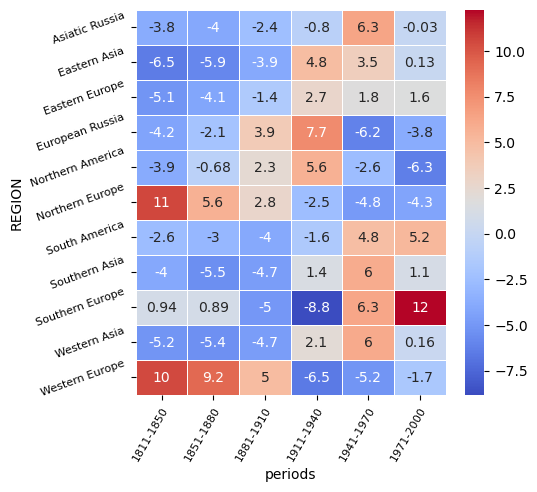

In [78]:
## Appliquer la fonction
bivariee_stats(D, figsize=(5,5))